![](img/573_banner.png)

# Lecture 8: Model transparency and conclusion 

UBC Master of Data Science program, 2022-23

Instructor: Varada Kolhatkar 

## Learning outcomes 

From this lecture, students are expected to be able to: 

- Explain why are transparency and interpretability important in ML.
- Use `feature_importances_` attribute of `sklearn` models and interpret its output. 
- Broadly explain how permutation feature importances are calculated and use `sklearn`'s `permutation_importance`.    
- Use `eli5` to get feature importances of non `sklearn` models and interpret its output. 
- Create shapely values associated with tree-based models using the SHAP tool.   
- Generate and interpret the force plot to explain a specific prediction. 
- Explain summary and dependence plots produced with shapely values.
- Learn to be aware of multicolinearity in your data when interpreting models.  

## Imports and LO

### Imports

In [1]:
import os
import sys

sys.path.append("code/.")
import string
from collections import deque

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.inspection import permutation_importance
from utils import *

<br><br>

## Transparency and explainability of ML models: Motivation 

### Activity (~5 mins)

Suppose you have a machine learning model which gives you a 98% cross-validation score (with the metric of your interest) and 97% test score on a reasonably sized train and test sets. Since you have impressive cross-validation and test scores, you decide to just trust the model and use it as a black box, ignoring why it's making certain predictions. 

Give some scenarios when this might or might not be problematic. Write your thoughts in [this Google document](https://docs.google.com/document/d/1nsOsdO-zRwvWWwM4-6h2t7eHgIhW8FCy3ebxoT7p0HY/edit#heading=h.tdmowxsyqy3f). 

<br><br><br><br>

### Why model transparency/interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 

![](img/shap_example.png)

<!-- <img src="img/shap_example.png" width="600" height="600"> -->
    
[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### What is model interpretability? 

- In this lecture, our definition of model interpretability will be looking at **feature importances**, i.e., exploring features which are important to the model. 
- There is more to interpretability than feature importances, but it's a good start!
- Resources: 
    - [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/interpretability-importance.html)
    - [Yann LeCun, Kilian Weinberger, Patrice Simard, and Rich Caruana: Panel debate on interpretability](https://vimeo.com/252187813)

<br><br>

### Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income) from the last lecture. 

In [2]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [3]:
numeric_features = ["age", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num", "fnlwgt"]
target_column = "income"

In [4]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [5]:
assert set(education_levels) == set(train_df["education"].unique())

In [6]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
tree_numeric_transformer = make_pipeline(SimpleImputer(strategy="median"))

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)

In [7]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

In [8]:
# encode categorical class values as integers for XGBoost
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_test_num = label_encoder.transform(y_test)

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [9]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    0.757985
>50K     0.242015
Name: income, dtype: float64

In [10]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [11]:
results = {}

We are going to use models outside sklearn. Some of them cannot handle categorical target values. So we'll convert them to integers using `LabelEncoder`. 

In [12]:
y_train_num

array([0, 0, 0, ..., 1, 1, 0])

### Baseline

In [13]:
dummy = DummyClassifier()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)

### Different models

In [14]:
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
classifiers = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}

In [15]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
    )

In [16]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Dummy,0.002 (+/- 0.001),0.000 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
logistic regression,0.477 (+/- 0.030),0.010 (+/- 0.002),0.849 (+/- 0.005),0.850 (+/- 0.001)
random forest,4.947 (+/- 0.149),0.087 (+/- 0.013),0.848 (+/- 0.006),0.979 (+/- 0.000)
XGBoost,0.837 (+/- 0.411),0.016 (+/- 0.004),0.870 (+/- 0.004),0.898 (+/- 0.001)
LightGBM,0.449 (+/- 0.076),0.017 (+/- 0.000),0.872 (+/- 0.004),0.888 (+/- 0.000)


- Logistic regression is giving reasonable scores but not the best ones. 
- XGBoost and LightGBM are giving us the best CV scores. 

- Often simple models (e.g., linear models) are interpretable but not very accurate.
- Complex models (e.g., LightGBM) are more accurate but less interpretable. 

![](img/shap_motivation.png)

<!-- <img src="img/shap_motivation.png" width="500" height="500"> -->

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### Feature importances in linear models

Let's create and fit a pipeline with preprocessor and logistic regression. 

In [17]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2))
pipe_lr.fit(X_train, y_train_num);

In [18]:
ohe_feature_names = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)
feature_names = (
    numeric_features + ordinal_features + binary_features + ohe_feature_names
)
feature_names[:15]

['age',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'workclass_missing']

In [19]:
data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)

In [20]:
coef_df[:10]

,coefficient,magnitude
capital.gain,2.356032,2.356032
marital.status_Married-AF-spouse,1.761385,1.761385
occupation_Priv-house-serv,-1.426083,1.426083
marital.status_Married-civ-spouse,1.347748,1.347748
relationship_Wife,1.289777,1.289777
native.country_Columbia,-1.080529,1.080529
occupation_Prof-specialty,1.078725,1.078725
occupation_Exec-managerial,1.056150,1.056150
native.country_Dominican-Republic,-1.009499,1.009499
relationship_Own-child,-0.985885,0.985885


- Increasing `capital.gain` is likely to push the prediction towards ">50k" income class 
- Whereas occupation of private house service is likely to push the prediction towards "<=50K" income. 

Can we get feature importances for non-linear models? 

<br><br>

## Model interpretability beyond linear models

- We will be looking at interpretability in terms of feature importances. 
- Note that there is no absolute or perfect way to get feature importances. But it's useful to get some idea on feature importances. So we just try our best. 

We will be looking at three ways to get feature importances. 

- `sklearn`'s `feature_importances_` and `permutation_importance`
- [eli5](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial) (stands for "explain like I'm 5") 
- [SHAP](https://github.com/slundberg/shap)    

### `sklearn`'s `feature_importances_` and `permutation_importance`

**Feature importance** or **variable importance** is a score associated with a feature which tells us how "important" the feature is to the model.

### Activity (~5 mins)

Linear models learn a coefficient associated with each feature which tells us the importance of the feature to the model. 
- What might be some reasonable ways to calculate feature importances of the following models? 
    - Decision trees    
    - Linear SVMs
    - KNNs, RBF SVMs
- Suppose you have correlated features in your dataset. Do you need to be careful about this when you examine feature importances? 

Discuss with your neighbour and write your ideas in this [Google doc](https://docs.google.com/document/d/1nsOsdO-zRwvWWwM4-6h2t7eHgIhW8FCy3ebxoT7p0HY/edit#heading=h.35fig6oxpil0). 

### Do we have correlated features? 

In [21]:
X_train_enc = preprocessor.fit_transform(X_train).todense()
corr_df = pd.DataFrame(X_train_enc, columns=feature_names).corr().abs()

In [22]:
corr_df[corr_df == 1] = 0 # Set the diagonal to 0. 

- Let's look at columns where any correlation number is > 0.80. 
- 0.80 is an arbitrary choice

In [23]:
high_corr = [column for column in corr_df.columns if any(corr_df[column] > 0.80)]
print(high_corr)

['workclass_missing', 'marital.status_Married-civ-spouse', 'occupation_missing', 'relationship_Husband']


Seems like there are some columns which are highly correlated.  

In [24]:
corr_df['occupation_missing']['workclass_missing']

0.9977957422135844

In [25]:
corr_df['marital.status_Married-civ-spouse']['relationship_Husband']

0.8937442459553657

- When we look at the feature importances, we should be mindful of these correlated features. 
- Remember the limitations of looking at simple linear correlations. 
- You should probably investigate multi-colinearity with more sophisticated approaches (e.g., variance inflation factors (VIF) from DSCI 561).   

### `sklearn`'s `feature_importances_` attribute vs `permutation_importance`

- Feature importances can be 
    - algorithm dependent, i.e., calculated based on the information given by the model algorithm (e.g., gini importance) 
    - model agnostic (e.g., by measuring increase in prediction error after permuting feature values). 
    
- Different measures give insight into different aspects of your data and model. 

> [Here](https://scikit-learn.org/stable/modules/permutation_importance.html#relation-to-impurity-based-importance-in-trees) you will find some drawbacks of using `feature_importances_` attribute  in the context of tree-based models.  

#### Decision tree feature importances 

In [26]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=3))
pipe_dt.fit(X_train, y_train_num);

In [27]:
data = {
    "Importance": pipe_dt.named_steps["decisiontreeclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]

,Importance
marital.status_Married-civ-spouse,0.543351
capital.gain,0.294855
education,0.160727
age,0.001068
native.country_Guatemala,0.000000
native.country_Iran,0.000000
native.country_India,0.000000
native.country_Hungary,0.000000
native.country_Hong,0.000000
native.country_Honduras,0.000000


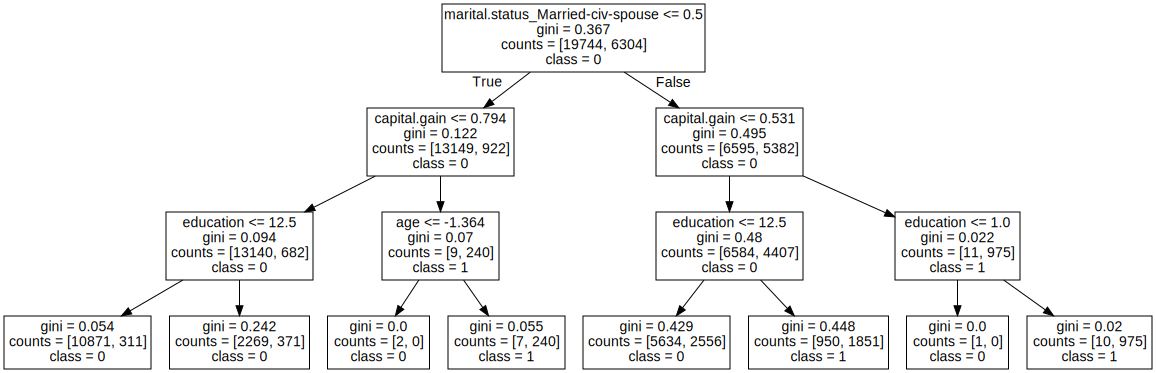

In [28]:
display_tree(feature_names, pipe_dt.named_steps["decisiontreeclassifier"], counts=True)

Let's explore permutation importance. 
- For each feature this method evaluates the impact of permuting feature values 

In [29]:
def get_permutation_importance(model):
    X_train_perm = X_train.drop(columns=["race", "education.num", "fnlwgt"])
    result = permutation_importance(model, X_train_perm, y_train_num, n_repeats=10, random_state=123)
    perm_sorted_idx = result.importances_mean.argsort()
    plt.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X_train_perm.columns[perm_sorted_idx],
    )
    plt.xlabel('Permutation feature importance')
    plt.show()

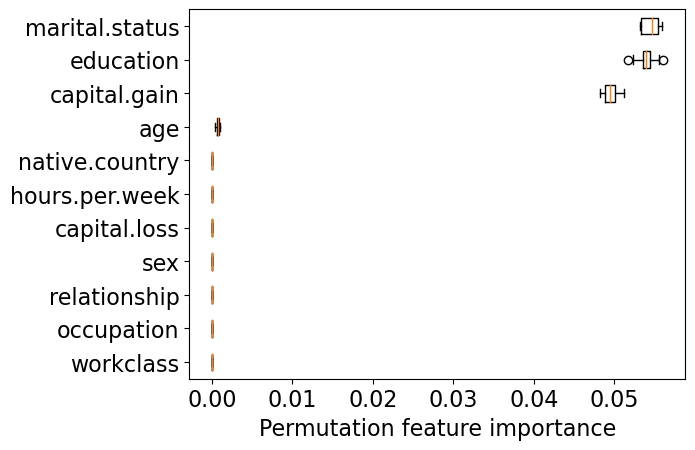

In [30]:
get_permutation_importance(pipe_dt)

Decision tree is primarily making all decisions based on three features: marital.status, education, and capital.gain. 

Let's create and fit a pipeline with preprocessor and random forest. 

#### Random forest feature importances

In [31]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2))
pipe_rf.fit(X_train, y_train_num);

Which features are driving the predictions the most? 

In [32]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
rf_imp_df = pd.DataFrame(
    data=data,
    index=feature_names,
).sort_values(by="Importance", ascending=False)

In [33]:
rf_imp_df[:8]

,Importance
age,0.229718
education,0.121846
hours.per.week,0.114966
capital.gain,0.114766
marital.status_Married-civ-spouse,0.077204
relationship_Husband,0.044253
capital.loss,0.038707
marital.status_Never-married,0.025489


In [34]:
np.sum(pipe_rf.named_steps["randomforestclassifier"].feature_importances_)

1.0

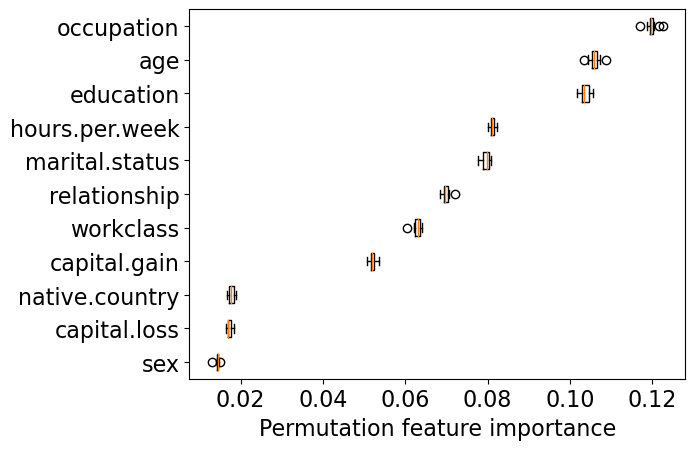

In [35]:
get_permutation_importance(pipe_rf)

Random forest is using more features in the model compared to decision trees. 

### Key point 

- Unlike the linear model coefficients, `feature_importances_` **do not have a sign**!
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear. 

### How can we get feature importances for non `sklearn` models? 

- One way to do it is by using a tool called [`eli5`](https://eli5.readthedocs.io/en/latest/overview.html).

I don't recall whether I included in the course conda environment or not. If not, you'll have to install it:

```
conda install -c conda-forge eli5
```

Let's look at feature importances for `XGBClassifier`. 

```{note}
For some reason, `eli5.explain_weights` doesn't work with the latest version of `xgboost`. I downgraded the `xgboost` version using this command to make it work `conda install -c conda-forge py-xgboost==1.3.0`. 

```

In [36]:
import eli5

pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)
pipe_xgb.fit(X_train, y_train_num)
eli5.explain_weights(pipe_xgb.named_steps["xgbclassifier"], feature_names=feature_names)

Weight,Feature
0.4838,marital.status_Married-civ-spouse
0.0477,capital.gain
0.0432,occupation_Other-service
0.0397,relationship_Own-child
0.0264,education
0.0243,capital.loss
0.0174,occupation_Exec-managerial
0.0167,occupation_Prof-specialty
0.0143,occupation_Tech-support
0.0138,occupation_Handlers-cleaners


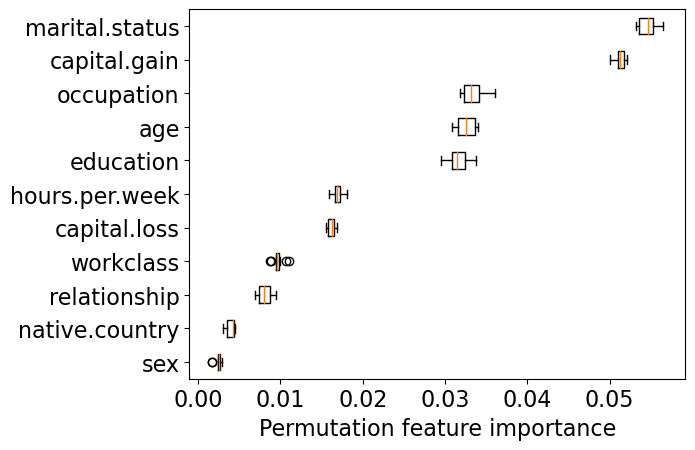

In [37]:
get_permutation_importance(pipe_xgb)

Let's look at feature importances for `LGBMClassifier`. 

In [38]:
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_lgbm.fit(X_train, y_train_num)
eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=feature_names
)

Weight,Feature
0.3613,marital.status_Married-civ-spouse
0.1941,capital.gain
0.1411,education
0.0890,age
0.0659,capital.loss
0.0440,hours.per.week
0.0131,occupation_Exec-managerial
0.0115,occupation_Prof-specialty
0.0072,occupation_Other-service
0.0063,sex


`marital.status_Married-civ-spouse` is showing up as an important feature in multiple models. Recall that this feature is highly correlated to `relationship_Husband`, which is not showing up as an important feature. If we remove the former, the latter is likely to show up as an important feature.       

In [39]:
corr_df['marital.status_Married-civ-spouse']['relationship_Husband']

0.8937442459553657

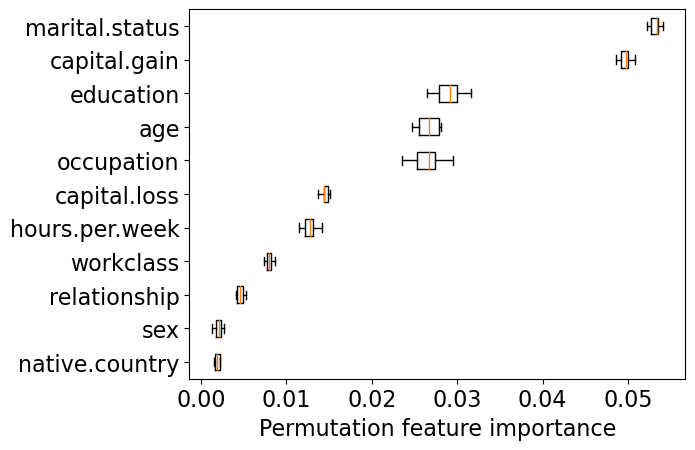

In [40]:
get_permutation_importance(pipe_lgbm)

You can also look at feature importances for `RandomForestClassifier`. 

In [41]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_rf.fit(X_train, y_train)

eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=feature_names
)

Weight,Feature
0.2319 ± 0.0434,age
0.1172 ± 0.0309,education
0.1160 ± 0.0214,hours.per.week
0.1126 ± 0.0479,capital.gain
0.0694 ± 0.1408,marital.status_Married-civ-spouse
0.0474 ± 0.1132,relationship_Husband
0.0386 ± 0.0140,capital.loss
0.0271 ± 0.0747,marital.status_Never-married
0.0245 ± 0.0269,occupation_Exec-managerial
0.0221 ± 0.0201,occupation_Prof-specialty


Let's compare them with weights what we got with `sklearn` `feature_importances_`

In [42]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]

,Importance
age,0.231860
education,0.117203
hours.per.week,0.116005
capital.gain,0.112640
marital.status_Married-civ-spouse,0.069385
relationship_Husband,0.047355
capital.loss,0.038566
marital.status_Never-married,0.027144
occupation_Exec-managerial,0.024527
occupation_Prof-specialty,0.022069


- These values tell us globally about which features are important.
- But what if you want to explain a _specific_ prediction. 
- Some fancier tools can help us do this.

<br><br><br><br>

### Break

![](img/eva-coffee.png)

## SHAP  (SHapley Additive exPlanations) introduction

### Explaining a prediction 

![](img/shap_example.png)
<!-- <img src="img/shap_example.png" width="600" height="600"> -->

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### SHAP  (SHapley Additive exPlanations)
- Based on the idea of shapely values. A shapely value is created for each example and each feature. 
- Can explain the prediction of an example by computing the contribution of each feature to the prediction. 
- Great visualizations 
- Support for different kinds of models; fast variants for tree-based models
- Original paper: [Lundberg and Lee, 2017](https://arxiv.org/pdf/1705.07874.pdf)

#### Our focus
- How to use it on our dataset?
- How to generate and interpret plots created by SHAP? 
- We are not going to discuss how SHAP works. 

![](img/shap_explanation2.png)
<!-- <img src="img/shap_explanation2.png" width="1000" height="1000"> -->

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)


- Start at a base rate (e.g., how often people get their loans rejected).
- Add one feature at a time and see how it impacts the decision. 

### SHAP on LGBM model 

- Let's try it out on our best performing LightGBM model. 
- You should have `shap` in the course conda environment

Let's create train and test dataframes with our transformed features. 

In [43]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,age,capital.gain,capital.loss,hours.per.week,education,sex,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,native.country_missing
5514,-0.921955,-0.147166,-0.21768,-1.258387,8.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19777,-1.069150,-0.147166,-0.21768,-0.447517,8.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10781,-0.185975,-0.147166,-0.21768,-0.042081,13.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32240,-1.216346,-0.147166,-0.21768,-1.663822,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9876,-0.553965,-0.147166,-0.21768,-0.042081,13.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.shape

(6513, 85)

Let's get SHAP values for train and test data. 

In [45]:
import shap

# Create a shap explainer object 
lgbm_explainer = shap.TreeExplainer(pipe_lgbm.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [46]:
train_lgbm_shap_values

[array([[ 4.08151507e-01,  2.82025568e-01,  4.70162085e-02, ...,
         -1.03017665e-03,  0.00000000e+00, -1.69027185e-03],
        [ 5.46019608e-01,  2.77536150e-01,  4.69698010e-02, ...,
         -9.00720988e-04,  0.00000000e+00, -6.78058051e-04],
        [-4.39095422e-01,  2.50475372e-01,  6.51137414e-02, ...,
         -9.02446630e-04,  0.00000000e+00, -3.54676006e-04],
        ...,
        [-1.05137470e+00,  1.89706451e-01, -2.74798624e+00, ...,
         -1.13229595e-03,  0.00000000e+00, -1.31449687e-04],
        [-6.32247597e-01,  3.01432486e-01,  8.99744241e-02, ...,
         -1.03411038e-03,  0.00000000e+00,  4.04709519e-04],
        [ 1.15559528e+00,  2.32397724e-01,  5.55862988e-02, ...,
         -1.05290827e-03,  0.00000000e+00, -8.11336331e-04]]),
 array([[-4.08151507e-01, -2.82025568e-01, -4.70162085e-02, ...,
          1.03017665e-03,  0.00000000e+00,  1.69027185e-03],
        [-5.46019608e-01, -2.77536150e-01, -4.69698010e-02, ...,
          9.00720988e-04,  0.00000000e

- For each example, each feature, and each class we have a SHAP value.
- SHAP values tell us how to fairly distribute the prediction among features. 
- For classification it's a bit confusing. It gives SHAP matrix for all classes.
- Let's stick to shap values for class 1, i.e., income > 50K. 

In [47]:
train_lgbm_shap_values[1].shape

(26048, 85)

In [48]:
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)
test_lgbm_shap_values[1].shape

(6513, 85)

<br><br>

## SHAP plots

In [49]:
# load JS visualization code to notebook
shap.initjs()

### Force plots

- Most useful! 
- Let's try to explain predictions on a couple of examples from the test data. 
- I'm sampling some examples where target is <=50K and some examples where target is >50K. 

In [50]:
y_test_reset = y_test.reset_index(drop=True)
y_test_reset

0       <=50K
1       <=50K
2       <=50K
3       <=50K
4       <=50K
        ...  
6508    <=50K
6509    <=50K
6510     >50K
6511    <=50K
6512     >50K
Name: income, Length: 6513, dtype: object

In [51]:
l50k_ind = y_test_reset[y_test_reset == "<=50K"].index.tolist()
g50k_ind = y_test_reset[y_test_reset == ">50K"].index.tolist()

ex_l50k_index = l50k_ind[10]
ex_g50k_index = g50k_ind[10]

### Explaining a prediction

Imagine that you are given the following test example. 

In [52]:
X_test_enc.iloc[ex_l50k_index]

age                               0.476406
capital.gain                     -0.147166
capital.loss                      4.649658
hours.per.week                   -0.042081
education                         8.000000
                                    ...   
native.country_Trinadad&Tobago    0.000000
native.country_United-States      1.000000
native.country_Vietnam            0.000000
native.country_Yugoslavia         0.000000
native.country_missing            0.000000
Name: 345, Length: 85, dtype: float64

You get the following hard prediction, which you are interested in explaining.  

In [53]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc)[ex_l50k_index]

0

You can first look at `predict_proba` output to get a better understanding of model confidence. 

In [54]:
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_l50k_index]

array([0.99240562, 0.00759438])

- The model seems quite confident. But if we want to know more, for example, which feature values are playing a role in this specific prediction, we can use SHAP force plots. 
- Remember that we have SHAP values per feature per example. We'll use these values to create SHAP force plot.  

In [55]:
pd.DataFrame(
    test_lgbm_shap_values[1][ex_l50k_index, :],
    index=feature_names,
    columns=["SHAP values"],
)

,SHAP values
age,0.723502
capital.gain,-0.253426
capital.loss,-0.256666
hours.per.week,-0.096692
education,-0.403715
...,...
native.country_Trinadad&Tobago,0.000000
native.country_United-States,0.003408
native.country_Vietnam,0.001051
native.country_Yugoslavia,0.000000


SHAP will produce the following type of plots.  

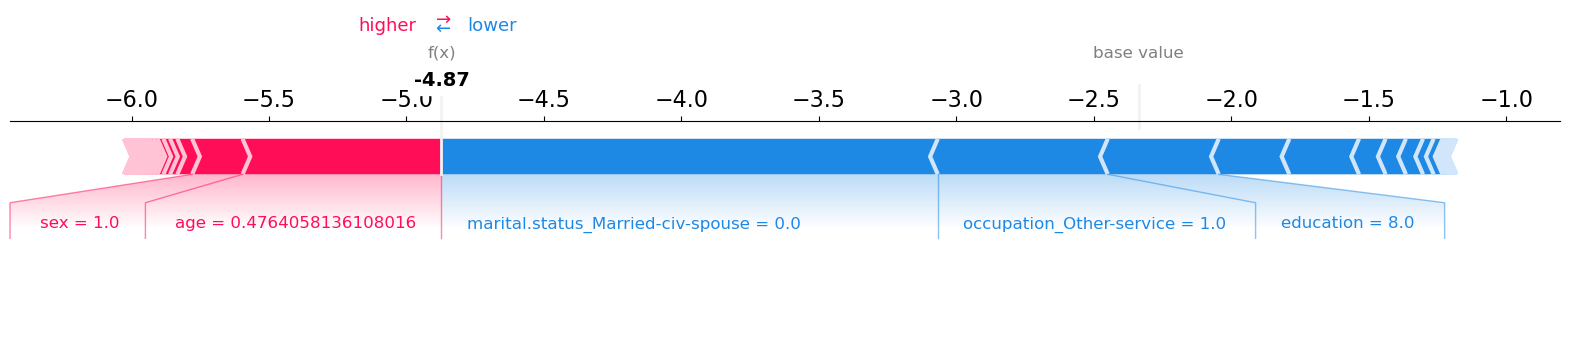

In [56]:
shap.force_plot(
    lgbm_explainer.expected_value[1], # expected value for class 1. 
    test_lgbm_shap_values[1][ex_l50k_index, :], # SHAP values associated with the example we want to explain
    X_test_enc.iloc[ex_l50k_index, :], # Feature vector of the example 
    matplotlib=True,
)

- The raw model score is much smaller than the base value, which is reflected in the prediction of <= 50k class. 
- sex = 1.0, scaled age = 0.48 are pushing the prediction towards higher score. 
- education = 8.0, occupation_Other-service = 1.0 and marital.status_Married-civ-spouse = 0.0 are pushing
the prediction towards lower score. 

In [57]:
pipe_lgbm.named_steps["lgbmclassifier"].classes_

array([0, 1])

We can get the raw model output by passing `raw_score=True` in `predict`. 

In [58]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)

array([-1.76270194, -7.61912405, -0.45555535, ...,  1.13521135,
       -6.62873917, -0.84062193])

What's the raw score of the example above we are trying to explain?  

In [59]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[ex_l50k_index]

-4.872722908439952

- The score matches with what we see in the force plot. 
- The base score above is the mean raw score. Our example has a lower raw score compared to the average raw score and the force plot tries to explain which feature values are bringing this score to a lower value. 

In [60]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_train_enc, raw_score=True).mean()

-2.336411423367732

In [61]:
lgbm_explainer.expected_value[1]  # on average this is the raw score for class 1

-2.3364114233677307

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [62]:
test_lgbm_shap_values[1][ex_l50k_index, :].sum() + lgbm_explainer.expected_value[1]

-4.8727229084399575

<br><br>

Now let's try to explain another prediction. 
- The hard prediction here is 1. 
- From the `predict_proba` output it seems like the model is not too confident about the prediction. 

In [63]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc)[ex_g50k_index]

1

In [64]:
# X_test_enc.iloc[ex_g50k_index]

In [65]:
pipe_lgbm.named_steps["lgbmclassifier"].predict_proba(X_test_enc)[ex_g50k_index]

array([0.35997929, 0.64002071])

What's the raw score for this example?

In [66]:
pipe_lgbm.named_steps["lgbmclassifier"].predict(X_test_enc, raw_score=True)[
    ex_g50k_index
]  # raw model score

0.5754540510801829

In [67]:
# pd.DataFrame(
#     test_lgbm_shap_values[1][ex_g50k_index, :],
#     index=feature_names,
#     columns=["SHAP values"],
# )

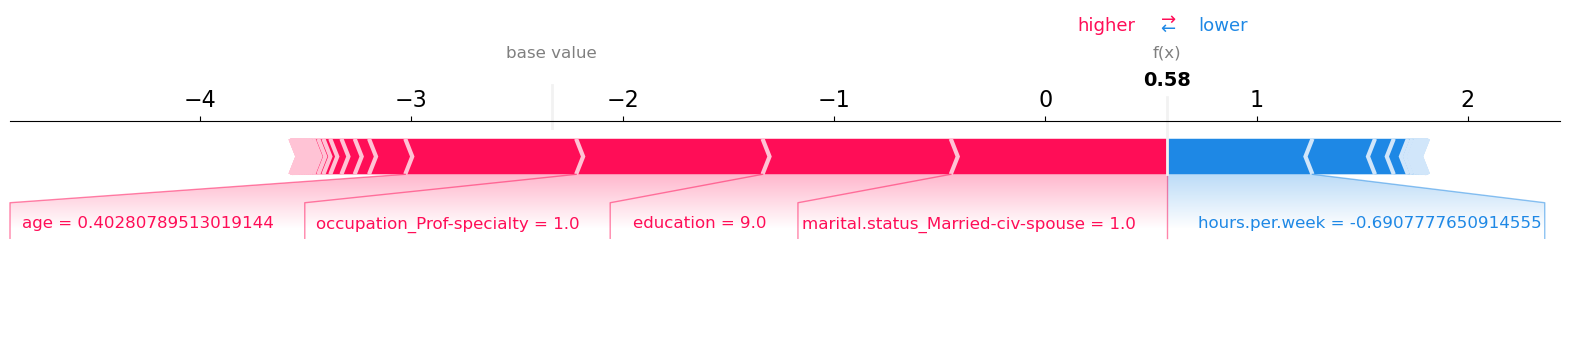

In [68]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][ex_g50k_index, :],
    X_test_enc.iloc[ex_g50k_index, :],
    matplotlib=True,
)

Observations: 

- Everything is with respect to class 1 here. 
- The base value, i.e., the average raw score for class 1 is -2.336. 
- We see the forces that drive the prediction. 
- That is, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 
- Features that push the prediction to a higher value are shown in red. 
- Features that push the prediction to a lower value are shown in blue.

<br><br>

### Global feature importance using SHAP

Let's look at the average SHAP values associated with each feature. 

In [69]:
values = np.abs(train_lgbm_shap_values[1]).mean(
    0
)  # mean of shapely values in each column
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
marital.status_Married-civ-spouse,1.074859
age,0.805468
capital.gain,0.565589
education,0.417642
hours.per.week,0.324636
sex,0.185687
capital.loss,0.148519
marital.status_Never-married,0.139914
relationship_Own-child,0.108003
occupation_Prof-specialty,0.106276


### Dependence plot

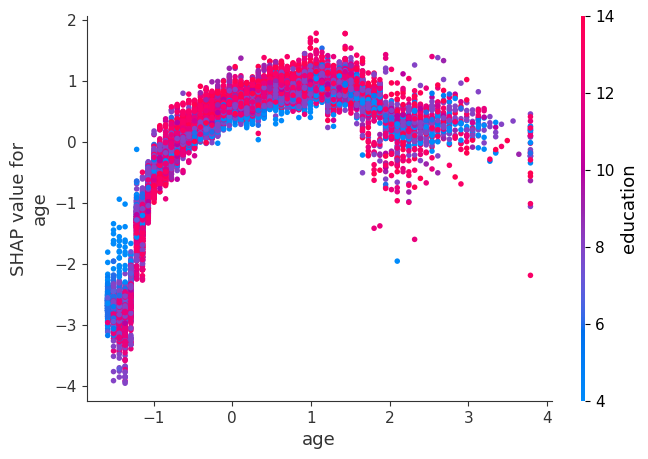

In [70]:
shap.dependence_plot("age", train_lgbm_shap_values[1], X_train_enc)

The plot above shows effect of `age` feature on the prediction. 

- Each dot is a single prediction for examples above.
- The x-axis represents values of the feature age (scaled).
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that example's prediction. 
- Lower values of age have smaller SHAP values for class ">50K".
- Similarly, higher values of age also have a bit smaller SHAP values for class ">50K", which makes sense.  
- There is some optimal value of age between scaled age of 1 which gives highest SHAP values for for class ">50K". 
- Ignore the colour for now. The color corresponds to a second feature (education feature in this case) that may have an interaction effect with the feature we are plotting. 

### Summary plot 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


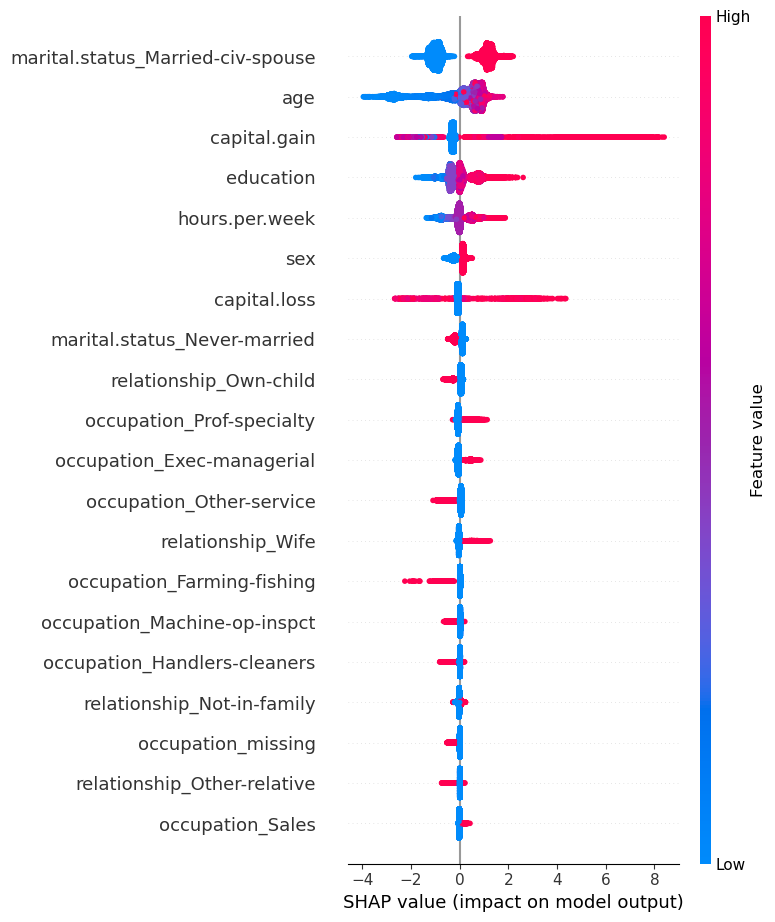

In [71]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

The plot shows the most important features for predicting the class. It also shows the direction of how it's going to drive the prediction.  

- Presence of the marital status of Married-civ-spouse seems to have bigger SHAP values for class 1 and absence seems to have smaller SHAP values for class 1. 
- Higher levels of education seem to have bigger SHAP values for class 1 whereas smaller levels of education have smaller SHAP values. 

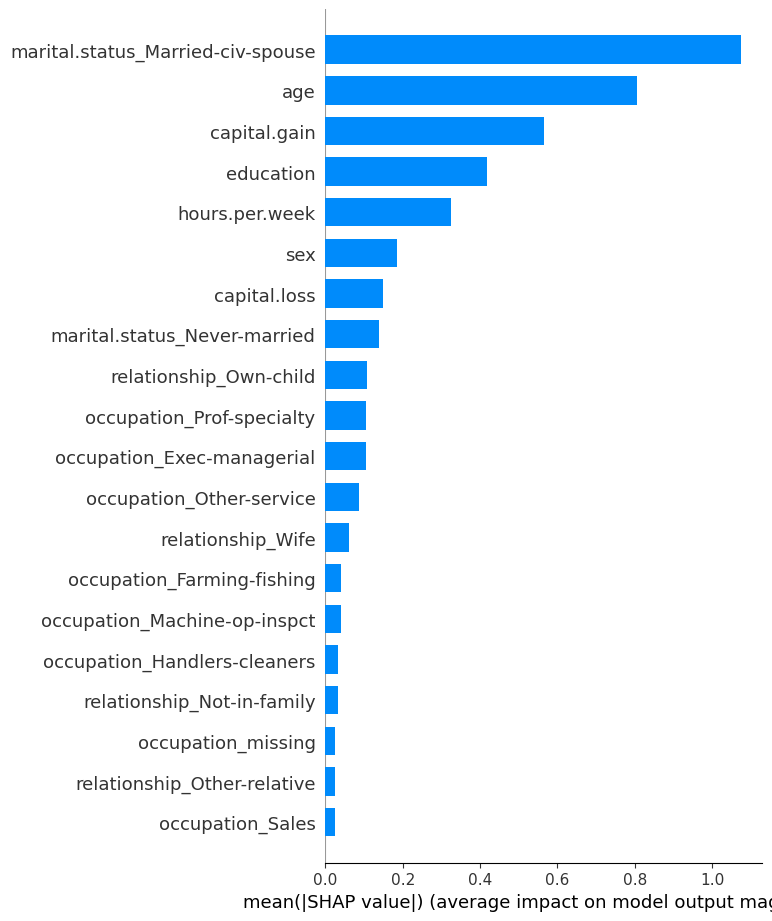

In [72]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

You can think of this as global feature importances.

<br><br>

Here, we explore SHAP's TreeExplainer. It also provides explainer for different kinds of models. 

- [TreeExplainer](https://shap.readthedocs.io/en/latest/) (supports XGBoost, CatBoost, LightGBM) 
- [DeepExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.DeepExplainer) (supports deep-learning models)
- [KernelExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.KernelExplainer) (supports kernel-based models)
- [GradientExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.GradientExplainer) (supports Keras and Tensorflow models)

- Can also be used to explain text classification and image classification 
- Example: In the picture below, red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. 

![](img/shap_image_explainer.png)
<!-- <img src="img/shap_image_explainer.png" width="600" height="600"> -->
    
[Source](https://github.com/slundberg/shap)

### Other tools

- [lime](https://github.com/marcotcr/lime) is another package.

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
- These tools work on other models as well, which makes them extremely useful.

#### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias. See [this](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Explaining%20quantitative%20measures%20of%20fairness.html). 
  - Keep in mind this can be used on **deployment** predictions!

Here are some guidelines and important points to remember when you work on a prediction problem where you also want to understand which features are influencing the predictions.  

- Examine multicoliniarity in your dataset using methods such as VIF. 
- If you observe high correlations in your dataset, either get rid of redundant features or be mindful of these correlations during interpretation. 
- Be mindful that feature relevance is not clearly defined. Adding/removing features can change feature importance/unimportance. Also, feature importances do not give us causal relationships. See [this optional section](https://pages.github.ubc.ca/mds-2022-23/DSCI_573_feat-model-select_students/lectures/04_feat-importances-selection.html#optional-problems-with-feature-selection) from Lecture 4. 
- Most of the models we use in ML are regularized models. With L2 regularization, the feature importances are distributed evenly among correlated features. With L1 regularization, one of the correlated features gets a high importance and the other gets a lower importance.
- Don't be overconfident. Always take feature importance values with a grain of salt.  

## What did we learn today? 

- Why interpretation?
- Interpretation in terms of feature importances
- Interpretation beyond linear models with eli5 
- Making sense of SHAP plots

## ❓❓ Questions for you

### iClicker Exercise 8.1 

**iClicker cloud join link: https://join.iclicker.com/C0P55**

**Select all the statements which are True.**

- (A) You train a random forest on a binary classification problem with two classes [neg, pos]. A value of 0.580 for feat1 given by `feature_importances_` attribute of your model means that increasing the value of feat1 will drive us towards positive class. 
- (B) eli5 can be used to get feature importances for non `sklearn` models. 
- (C) With SHAP you can only explain predictions on the training examples. 

**V's answers: B**

- In what scenarios interpretability can be harmful? 

<br><br><br><br>

## Final comments

- We started with building a preliminary supervised machine learning pipeline. 
- Now we are refining the pipeline by adding more components in it. 

<img src="img/ml-workflow.png" height="800" width="800"> 

### Some key takeaways

Some useful guidelines:

- Do train-test split right away and only once
- Don't look at the test set until the end
- Don't call `fit` on test/validation data
- Use pipelines
- Use baselines
- Do not be overconfident about your models. They do not tell us how the world works. 

### Difference between Statistics and Machine Learning
- There is no clear boundary. 
- But loosely
    - in statistics the emphasis is on inference (usually framed as hypothesis testing)
    - in machine learning the emphasis is on prediction and generalization. We are primarily interested in using our model on new unseen examples. 

### Recipe to approach a supervised learning problem with tabular data 

#### Understanding the problem

1. Have a long conversation with the stakeholder(s) who will be using your pipeline. 
2. Have a long conversation with the person(s) who collected the data.
3. Think about 
    - what do you want to accomplish?
    - whether you really need to use machine learning for the problem or not
    - how do you want to frame the problem as a supervised machine learning problem? What do you want to predict? 
    - how do you plan to measure your success? 
    - is there a baseline? 
    - is there any operating point? 
    - what will it buy the stakeholders if you improve over their current baseline?  
4. Think about the ethical implications - are you sure you want to do this project? If so, should ethics guide your approach?


#### Initial analysis, EDA, preprocessing
1. Random train-test split with fixed random seed; do not touch the test data until Step 16.
2. Exploratory data analysis, outlier detection.
3. Choose a scoring metric -> higher values should make you & your stakeholders happier.
4. Feature engineering --> Create new features which might be useful to solve the prediction problem. This is typically a time-consuming process. Also, sometimes you get an idea of good features only after looking at your model results. So it's an iterative process. 
5. Fit a baseline model, e.g. `DummyClassifier` or `DummyRegressor`.
6. Create a preprocessing pipeline. 
7. (Optional) Incorporate feature selection. 

#### Model building 
1. Try a linear model, e.g. `LogisticRegression` for classification or `Ridge`; tune hyperparameters with CV.
2. Try other sensible model(s), e.g. LightGBM; tune hyperparameters with CV.
3. For each model, look at sub-scores from the folds of cross-validation to get a sense of "error bars" on the scores.
4. Pick a few reasonable models. Best CV score is a reasonable metric, though you may choose to favour simpler models.
5. Carry out hyperparameter optimization for these models, paying attention to whether you are not susceptible to optimization bias. 
6. Try averaging and stacking to examine whether you improve the results over  your best-performing models.  

### Model transparency and interpretation 
1. Look at feature importances.
2. (optional) Perform some more diagnostics like confusion matrix for classification, or "predicted vs. true" scatterplots for regression.
3. (optional) Try to calibrate the uncertainty/confidence outputted by your model.
4. Test set evaluation.
5. Model transparency. Take a random sample from the test data and try to explain your predictions using SHAP plots. 
6. Question everything again: validity of results, bias/fairness of trained model, etc.
7. Concisely summarize your results and discuss them with stakeholders.
8. (optional) Retrain on all your data.
9. Deployment & integration.

PS: the order of steps is approximate, and some steps may need to be repeated during prototyping, experimentation, and as needed over time.

### Coming up 
- We haven't talked about deep learning and working with images yet. It's coming up in block 5 (DSCI 572).  
- Supervised learning is quite successful but many well-known people in the field believe that it's fundamentally limited, as it doesn't seem to be how humans learn. We'll learn about unsupervised learning in block 5 (DSCI 563).   
- Forecasting and time series is another important area in machine learning. You'll be learning about it in block 5 (DSCI 574)  
- Finally, we'll talk about sequential models for text data in block 6 (DSCI 575)

## Farewell

That's all, folks. We made it! Good luck with the quiz next week. Happy holidays and I'll see you in block 5! 


![](img/eva-congrats.png)

### Time for course evaluations

- We are happy to hear your thoughts on this course. 
Here is the link: https://canvas.ubc.ca/courses/102041/external_tools/4732